<a href="https://colab.research.google.com/github/aghosh92/ML-ElectronMicroscopy-2023/blob/main/Lecture%2012/Optional_Notebook_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Notebook is prepared by Ayana Ghosh**

Email: research.aghosh@gmail.com

### This notebook shows an example how to use the simulation object as prepared by AtomAI to run a sample MD simulation with ASE.

### The example follows a similar workflow (simulation object prepared by AtomAI to perform simulations) as described in this paper, https://www.nature.com/articles/s41524-022-00733-7, provided DFT simulations were performed in this work for structure optimization followed by finite temperature AIMD simulations were performed on patches of the full system to generate results on energy landscape, dopant and graphene healing effects.

In [ ]:
#@title Install packages
!pip install ase
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=d1f9b9e8bc6105eac3dbac9eeee32e75762ae272c862b4ed881a73d5ef6c1d01
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
#@title Import essential libraries
import os
import numpy as np
from ase import Atoms, Atom
import ase.io as io

from ase.io import read,write
from ase.io.vasp import read_vasp
from ase.calculators.lammpslib import LAMMPSlib
from ase.io.trajectory import Trajectory
from ase.optimize import QuasiNewton
from ase.optimize.bfgslinesearch import BFGSLineSearch
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.io.animation import write_mp4
from ase.calculators.lj import LennardJones
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
from ase.data.colors import jmol_colors
from ase.data import covalent_radii
from ase.geometry import wrap_positions

import cv2 as cv
import glob
import imageio
import wget

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in the newly created object that is readable by ASE that can be used to perform molecular dynamics simulations.

In [ ]:
# #drive link
# !gdown https://drive.google.com/uc?id=1ByrcGe0sMsrx5iW4jj5S3oAAYa0kC70C
!wget -O POSCAR_basic https://www.dropbox.com/s/nqbl7th8mnea7mf/POSCAR_basic?dl=0
atoms = io.vasp.read_vasp("POSCAR_basic")

--2023-07-12 23:49:11--  https://www.dropbox.com/s/nqbl7th8mnea7mf/POSCAR_basic?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nqbl7th8mnea7mf/POSCAR_basic [following]
--2023-07-12 23:49:12--  https://www.dropbox.com/s/raw/nqbl7th8mnea7mf/POSCAR_basic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc716b3679bcb7a8e10f682078c2.dl.dropboxusercontent.com/cd/0/inline/B_uLJqbkYWH4j9TFXRd3eHYmiV2x7XLVPbCqNEe4mjMiZolY5HGZ7_FMjbQM24EqyWZT26MEo7kgn1caqxEbesPgTeOAijIo5TtbPhso3lJlnmQfebmNag8N32o_A_fI8NVIjIKmoULb9Y2qytxA25af_vViuLJIan59VVsKupqXgQ/file# [following]
--2023-07-12 23:49:12--  https://uc716b3679bcb7a8e10f682078c2.dl.dropboxusercontent.com/cd/0/inline/B_uLJqbkYWH4j9TFXRd3eHYmiV2x7XLVPbCqNEe4mjMiZolY5HGZ7_FMjbQM24EqyWZT26ME

In [ ]:
def printenergy(a):
# function to print the potential, kinetic and total energy
  epot = a.get_potential_energy() / len(a)
  ekin = a.get_kinetic_energy() / len(a)
  print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
  return epot, ekin

This is an example without the geometry optimization as implemented in ASE.
We're just using LJ potential as an example here.

In [ ]:
#setting the calculator
calc = LennardJones()
atoms.calc= calc

# do a quick geometry relaxation
#qn = QuasiNewton(atoms)
#qn.run(1e-4, 50) #convergence criteria

# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)
Stationary(atoms) # zero linear momentum
ZeroRotation(atoms) # zero angular momentum

# run MD with constant energy using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1 * units.fs, trajectory='/content/drive/My Drive/trial.traj')

# now run the dynamics
epot_list_plot=[]
ekin_list_plot=[]
positions = []
printenergy(atoms)

for k in range(5):
  loc_pos = []
  dyn.run(5) # number of steps

  printenergy(atoms)
  epot_temp, ekin_temp = printenergy(atoms)
  epot_list_plot.append(epot_temp)
  ekin_list_plot.append(ekin_temp)
  pos_atoms = atoms.get_positions(wrap=True) #for getting the positions of the atoms after the last timestep
  loc_pos.append(pos_atoms)
  positions.append(loc_pos)

Energy per atom: Epot = -0.536eV  Ekin = 0.039eV (T=302K)  Etot = -0.497eV
Energy per atom: Epot = -0.543eV  Ekin = 0.047eV (T=361K)  Etot = -0.497eV
Energy per atom: Epot = -0.543eV  Ekin = 0.047eV (T=361K)  Etot = -0.497eV
Energy per atom: Epot = -0.571eV  Ekin = 0.074eV (T=571K)  Etot = -0.497eV
Energy per atom: Epot = -0.571eV  Ekin = 0.074eV (T=571K)  Etot = -0.497eV
Energy per atom: Epot = -0.614eV  Ekin = 0.117eV (T=901K)  Etot = -0.497eV
Energy per atom: Epot = -0.614eV  Ekin = 0.117eV (T=901K)  Etot = -0.497eV
Energy per atom: Epot = -0.664eV  Ekin = 0.167eV (T=1292K)  Etot = -0.497eV
Energy per atom: Epot = -0.664eV  Ekin = 0.167eV (T=1292K)  Etot = -0.497eV
Energy per atom: Epot = -0.708eV  Ekin = 0.210eV (T=1627K)  Etot = -0.498eV
Energy per atom: Epot = -0.708eV  Ekin = 0.210eV (T=1627K)  Etot = -0.498eV


In [ ]:
traj = Trajectory('/content/drive/My Drive/trial.traj')

/usr/local/lib/python3.10/dist-packages/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=26.
  animation = FuncAnimation(fig, drawimage, frames=images,


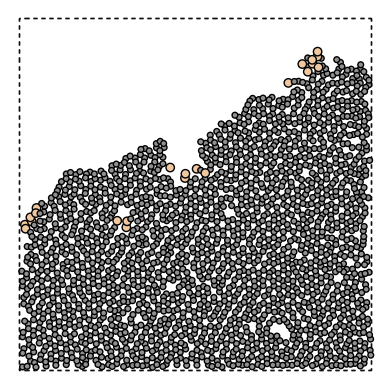

In [ ]:
write_mp4('/content/drive/My Drive/trial.mp4',traj)